# **Implementación de modelos para el análisis de sentimiento**

## ***Librerias***

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec
from sklearn import utils
from tqdm import tqdm
from collections import Counter
import itertools

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


In [4]:
nltk.data.path.append('C:\\nltk_data')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fonta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **Modelo Doc2Vec**

En esta sección se implementa y entrena un modelo Dock2Vec con el fin de poder tokenizar cada uno de los mensages que se encuentran en nuestro dataset de interés a clasificar.

In [5]:
data=pd.read_csv('data/processed/to_model.csv')
data = data.dropna(subset=['clean_text'])

In [6]:
data.head(7)

,label,clean_text
0,neg,achanak khawaja saad rafiqu khiyaal aagaya woh...
1,neg,adha drama to censor hi hojay gaa khaa tor bas...
2,neg,bekaar fuzool end moti budhi laila jeet gaye l...
3,neg,choor kasuri choor jhootay moo kaala
4,neg,gali gali mein shor gaaanjaaaa shair chor
5,neg,hum kia hamari logic kia bhonkoon mute bhonk a...
6,neg,imran khan altaf hussain chachoo haroon sadmey...


In [7]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [8]:
print(f'Tamaño conjunto de entrenamiento {train.shape}')
print(f'Tamaño conjunto de test {test.shape}')

Tamaño conjunto de entrenamiento (8797, 2)
Tamaño conjunto de test (2200, 2)


In [9]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [10]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['clean_text']), tags=[r.label]), axis=1)
test_tagged  = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['clean_text']), tags=[r.label]), axis=1)

In [11]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=12, alpha=0.065, min_alpha=0.065)

In [12]:
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 8797/8797 [00:00<00:00, 2551856.44it/s]


In [13]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 8797/8797 [00:00<00:00, 2924179.13it/s]


CPU times: total: 42 s
Wall time: 33.2 s


In [14]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001,t12>


In [15]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

In [16]:
for i in range(len(d2v_model.dv)):
    vec = d2v_model.dv[i]
    if vec is not None and len(vec) <= 1000:
        print(i)
        print(d2v_model.dv)
        embedding_matrix[i] = vec
        print(vec)

0
KeyedVectors<vector_size=20, 2 keys>
[-2.0149918  -6.4373016  -1.5135429   2.1203213   0.41946024 -1.7373773
 -7.0389924  -0.8602019  -2.8958862  -1.8635395   2.466731    0.7813484
  3.4586127  -0.8055514  -5.287859   -5.2861586  -3.9475093   4.1923256
 -4.275979   -1.4629108 ]
1
KeyedVectors<vector_size=20, 2 keys>
[-0.88639134  4.1631756  -4.334069    1.481545    3.0769541  -2.8361197
 -0.25752407 -3.673615    3.137438   -0.79327774  0.11603083  1.8300955
 -5.237374   -0.20730858  1.2305442   2.2621813   3.0822544  -4.1048684
 -2.6952367  -1.3975406 ]


## **Preproscesamiento**

In [17]:
all_words = list(itertools.chain.from_iterable(data['clean_text'].apply(lambda x: x.split())))
word_counts = Counter(all_words)
print(f"Total de palabras únicas: {len(word_counts)}")

Total de palabras únicas: 26381


In [18]:
data['clean_text'].apply(lambda x: len(x.split())).describe()

count    10997.000000
mean        18.492134
std         21.542020
min          1.000000
25%          7.000000
50%         12.000000
75%         21.000000
max        356.000000
Name: clean_text, dtype: float64

In [19]:
max_features = 5000
MAX_SEQUENCE_LENGTH = 75

In [20]:
tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[$$^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['clean_text'].values)
X = tokenizer.texts_to_sequences(data['clean_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 10997 unique tokens.
Shape of data tensor: (10997, 75)


In [21]:
le = LabelEncoder()
Y = le.fit_transform(data['label'])

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [23]:
print(f'Tamaño conjunto de entrenamiento {X_train.shape}')
print(f'Tamaño conjunto de test {X_test.shape}')

Tamaño conjunto de entrenamiento (8797, 75)
Tamaño conjunto de test (2200, 75)


In [48]:
Metricas_totales =pd.DataFrame()

## **LSTM**

### **Entrenamiento**

In [32]:
def create_model(lstm_units=64, num_lstm_layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))
    
    for i in range(num_lstm_layers):
        return_seq = (i < num_lstm_layers - 1)
        model.add(LSTM(units=lstm_units, return_sequences=return_seq))

    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model


In [33]:
model = KerasClassifier(build_fn=create_model,verbose=0)

param_grid = {
    'lstm_units': [64],
    'num_lstm_layers': [1, 2],
    'dropout_rate': [0.2],
    'learning_rate': [0.001],
    'batch_size': [32, 64],
    'epochs': [20, 50],
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy',verbose=2)

In [34]:
grid_result = grid.fit(X_train, Y_train, verbose=1)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/20
184/184 [==============================] - 3s 10ms/step - loss: 0.6699 - accuracy: 0.5829
Epoch 2/20
184/184 [==============================] - 2s 10ms/step - loss: 0.4823 - accuracy: 0.7742
Epoch 3/20
184/184 [==============================] - 2s 10ms/step - loss: 0.3105 - accuracy: 0.8730
Epoch 4/20
184/184 [==============================] - 2s 10ms/step - loss: 0.2307 - accuracy: 0.9098
Epoch 5/20
184/184 [==============================] - 2s 10ms/step - loss: 0.1811 - accuracy: 0.9306
Epoch 6/20
184/184 [==============================] - 2s 10ms/step - loss: 0.1369 - accuracy: 0.9533
Epoch 7/20
184/184 [==============================] - 2s 11ms/step - loss: 0.1125 - accuracy: 0.9633
Epoch 8/20
184/184 [==============================] - 2s 10ms/step - loss: 0.0983 - accuracy: 0.9656
Epoch 9/20
184/184 [==============================] - 2s 10ms/step - loss: 0.0802 - accuracy: 0.9748
Epoch 10/20
184/184 [==========

In [41]:
print("🏆 Mejores parámetros:", grid_result.best_params_)
print("✅ Mejor accuracy en CV:", grid_result.best_score_)

results = pd.DataFrame(grid_result.cv_results_)
results.to_csv('data/processed/resultados_lstm.csv')
results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

🏆 Mejores parámetros: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': 64, 'num_lstm_layers': 1}
✅ Mejor accuracy en CV: 0.7504821954373769


,params,mean_test_score,std_test_score,rank_test_score
4,"{'batch_size': 64, 'dropout_rate': 0.2, 'epoch...",0.750482,0.007023,1
5,"{'batch_size': 64, 'dropout_rate': 0.2, 'epoch...",0.750256,0.004040,2
1,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.749800,0.009861,3
0,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.745141,0.007408,4
7,"{'batch_size': 64, 'dropout_rate': 0.2, 'epoch...",0.744572,0.009331,5


In [42]:
yhat_probs_lstm = grid_result.predict(X_test)
df_pred = pd.DataFrame(yhat_probs_lstm, columns=['prediccion'])
df_pred.to_csv('data/processed/predicciones_lstm.csv', index=False)

69/69 [==============================] - 1s 9ms/step


### **Resultados**

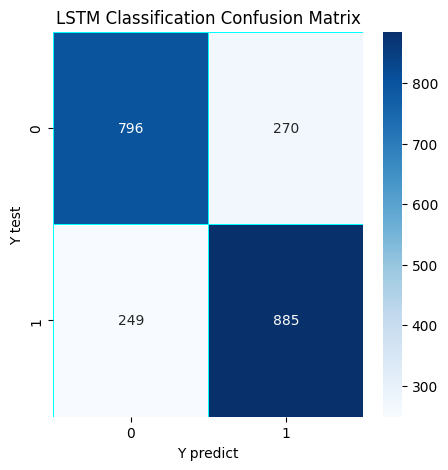

In [44]:
lstm_val = confusion_matrix(Y_test, yhat_probs_lstm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="Blues")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [51]:
metrics_lstm=[]
precision = precision_score(Y_test, yhat_probs_lstm)
recall = recall_score(Y_test, yhat_probs_lstm)
f1 = f1_score(Y_test, yhat_probs_lstm)
accuracy = accuracy_score(Y_test, yhat_probs_lstm)

metrics_lstm = [{
    'Modelo': 'LSTM',
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4),
    'Accuracy': round(accuracy, 4)
}]

# Convertir en DataFrame y mostrarlo
df_metrics = pd.DataFrame(metrics_lstm)
Metricas_totales = pd.concat([Metricas_totales, df_metrics], ignore_index=True)
df_metrics


,Modelo,Precision,Recall,F1 Score,Accuracy
0,LSTM,0.7662,0.7804,0.7733,0.7641


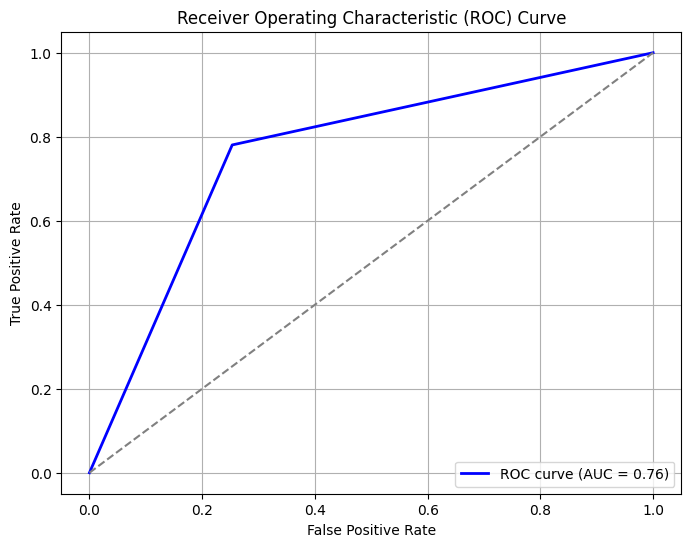

In [45]:
fpr, tpr, thresholds = roc_curve(Y_test, yhat_probs_lstm)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## **RNN**

### **Entrenamiento**

In [24]:
def create_rnn_model(rnn_units=64, num_rnn_layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(len(d2v_model.wv.key_to_index) + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))
    
    for i in range(num_rnn_layers):
        return_seq = (i < num_rnn_layers - 1)
        model.add(SimpleRNN(units=rnn_units, return_sequences=return_seq))

    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model


In [25]:
model_rnn = KerasClassifier(build_fn=create_rnn_model, verbose=0)

param_grid_rnn = {
    'rnn_units': [64, 128],
    'num_rnn_layers': [1],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001],
    'batch_size': [32, 64],
    'epochs': [20, 50]
}

grid_rnn = GridSearchCV(estimator=model_rnn, param_grid=param_grid_rnn, cv=3, scoring='accuracy',verbose=2)

In [26]:
grid_result_rnn = grid_rnn.fit(X_train, Y_train, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/20
184/184 [==============================] - 23s 108ms/step - loss: 0.6775 - accuracy: 0.5812
Epoch 2/20
184/184 [==============================] - 20s 108ms/step - loss: 0.5431 - accuracy: 0.7271
Epoch 3/20
184/184 [==============================] - 19s 104ms/step - loss: 0.3536 - accuracy: 0.8530
Epoch 4/20
184/184 [==============================] - 21s 113ms/step - loss: 0.2324 - accuracy: 0.9096
Epoch 5/20
184/184 [==============================] - 20s 107ms/step - loss: 0.1579 - accuracy: 0.9405
Epoch 6/20
184/184 [==============================] - 20s 108ms/step - loss: 0.1101 - accuracy: 0.9627
Epoch 7/20
184/184 [==============================] - 20s 108ms/step - loss: 0.0761 - accuracy: 0.9749
Epoch 8/20
184/184 [==============================] - 21s 112ms/step - loss: 0.0594 - accuracy: 0.9823
Epoch 9/20
184/184 [==============================] - 21s 113ms/step - loss: 0.0408 - accuracy: 0.9881
Epoch 10/20


In [ ]:
print("🏆 Mejores parámetros:", grid_result_rnn.best_params_)
print("✅ Mejor accuracy en CV:", grid_result_rnn.best_score_)

results = pd.DataFrame(grid_result_rnn.cv_results_)
results.to_csv('data/processed/resultados_rnn.csv')
results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

🏆 Mejores parámetros: {'batch_size': 64, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'num_rnn_layers': 1, 'rnn_units': 64}
✅ Mejor accuracy en CV: 0.7503702516734584


,params,mean_test_score,std_test_score,rank_test_score
8,"{'batch_size': 64, 'dropout_rate': 0.2, 'epoch...",0.750370,0.009393,1
7,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.745936,0.007104,2
5,"{'batch_size': 32, 'dropout_rate': 0.5, 'epoch...",0.745822,0.007124,3
13,"{'batch_size': 64, 'dropout_rate': 0.5, 'epoch...",0.745255,0.012801,4
0,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.745142,0.008735,5


In [37]:
yhat_probs = grid_result_rnn.predict(X_test)
df_pred = pd.DataFrame(yhat_probs, columns=['prediccion'])
df_pred.to_csv('data/processed/predicciones_rnn.csv', index=False)

69/69 [==============================] - 1s 17ms/step


### **Resultados**

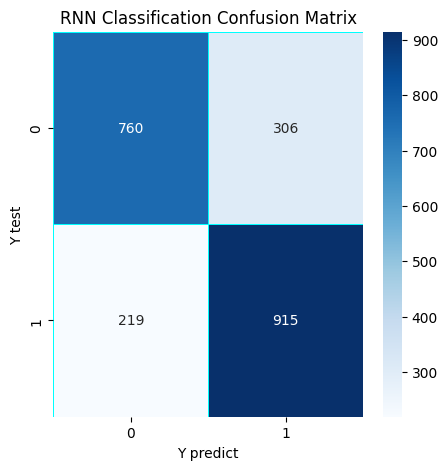

In [29]:
lstm_val = confusion_matrix(Y_test, yhat_probs)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="Blues")
plt.title('RNN Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [57]:
metrics_rnn=[]
precision = precision_score(Y_test, yhat_probs)
recall = recall_score(Y_test, yhat_probs)
f1 = f1_score(Y_test, yhat_probs)
accuracy = accuracy_score(Y_test, yhat_probs)

metrics_rnn = [{
    'Modelo': 'RNN',
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4),
    'Accuracy': round(accuracy, 4)
}]

# Convertir en DataFrame y mostrarlo
df_metrics = pd.DataFrame(metrics_rnn)
Metricas_totales=pd.concat([Metricas_totales, df_metrics], ignore_index=True)
df_metrics


,Modelo,Precision,Recall,F1 Score,Accuracy
0,RNN,0.7494,0.8069,0.7771,0.7614


In [55]:
yhat_probs=pd.read_csv('data/processed/predicciones_rnn.csv')

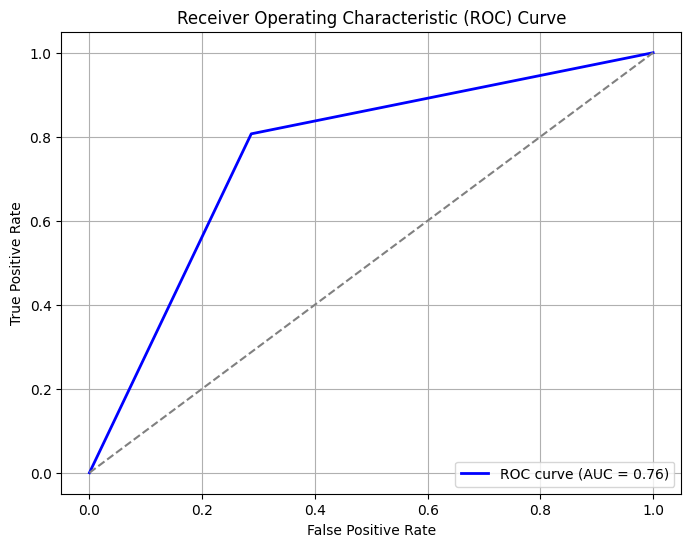

In [56]:
fpr, tpr, thresholds = roc_curve(Y_test, yhat_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## **GRU**

### **Entrenamiento**

In [25]:
def create_gru_model(gru_units=64, num_gru_layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(
        input_dim=len(d2v_model.wv.key_to_index) + 1,
        output_dim=20,
        input_length=X.shape[1],
        weights=[embedding_matrix],
        trainable=True
    ))

    for i in range(num_gru_layers):
        return_seq = (i < num_gru_layers - 1)
        model.add(GRU(units=gru_units, return_sequences=return_seq))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model

In [29]:
model_gru = KerasClassifier(build_fn=create_gru_model, verbose=0)

# Definir la malla de hiperparámetros
param_grid_gru = {
    'gru_units': [64, 128],
    'num_gru_layers': [1],
    'dropout_rate': [0.2],
    'learning_rate': [0.001],
    'batch_size': [32, 64],
    'epochs': [20, 50]
}

# Búsqueda en malla
grid_gru = GridSearchCV(estimator=model_gru, param_grid=param_grid_gru,cv=3,scoring='accuracy', verbose=2)


In [30]:
grid_result_gru = grid_gru.fit(X_train, Y_train, verbose=1)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/20
184/184 [==============================] - 4s 14ms/step - loss: 0.6604 - accuracy: 0.5921
Epoch 2/20
184/184 [==============================] - 3s 14ms/step - loss: 0.4398 - accuracy: 0.7989
Epoch 3/20
184/184 [==============================] - 3s 14ms/step - loss: 0.2890 - accuracy: 0.8817
Epoch 4/20
184/184 [==============================] - 3s 14ms/step - loss: 0.2123 - accuracy: 0.9185
Epoch 5/20
184/184 [==============================] - 3s 14ms/step - loss: 0.1592 - accuracy: 0.9441
Epoch 6/20
184/184 [==============================] - 2s 13ms/step - loss: 0.1271 - accuracy: 0.9560
Epoch 7/20
184/184 [==============================] - 2s 13ms/step - loss: 0.0990 - accuracy: 0.9676
Epoch 8/20
184/184 [==============================] - 2s 13ms/step - loss: 0.0776 - accuracy: 0.9756
Epoch 9/20
184/184 [==============================] - 2s 13ms/step - loss: 0.0709 - accuracy: 0.9792
Epoch 10/20
184/184 [==========

In [31]:
print("🏆 Mejores parámetros:", grid_result_gru.best_params_)
print("✅ Mejor accuracy en CV:", grid_result_gru.best_score_)

results = pd.DataFrame(grid_result_gru.cv_results_)
results.to_csv('data/processed/resultados_gru.csv')
results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

🏆 Mejores parámetros: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'gru_units': 64, 'learning_rate': 0.001, 'num_gru_layers': 1}
✅ Mejor accuracy en CV: 0.7505970075664372


,params,mean_test_score,std_test_score,rank_test_score
0,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.750597,0.001334,1
1,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.749687,0.006132,2
5,"{'batch_size': 64, 'dropout_rate': 0.2, 'epoch...",0.747869,0.004723,3
4,"{'batch_size': 64, 'dropout_rate': 0.2, 'epoch...",0.747869,0.007428,4
3,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",0.742526,0.007519,5


In [36]:
yhat_probs_gru = grid_result_gru.predict(X_test)
df_pred = pd.DataFrame(yhat_probs_gru, columns=['prediccion'])
df_pred.to_csv('data/processed/predicciones_gru.csv', index=False)

69/69 [==============================] - 1s 7ms/step


### **Resultados**

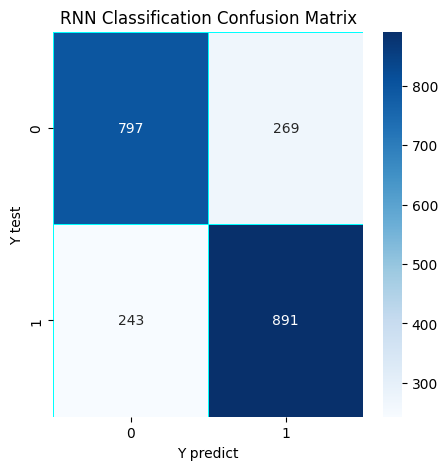

In [37]:
gru_val = confusion_matrix(Y_test, yhat_probs_gru)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(gru_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="Blues")
plt.title('RNN Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [59]:
metrics_gru=[]
precision = precision_score(Y_test, yhat_probs_gru)
recall = recall_score(Y_test, yhat_probs_gru)
f1 = f1_score(Y_test, yhat_probs_gru)
accuracy = accuracy_score(Y_test, yhat_probs_gru)

metrics_gru = [{
    'Modelo': 'GRU',
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4),
    'Accuracy': round(accuracy, 4)
}]

# Convertir en DataFrame y mostrarlo
df_metrics = pd.DataFrame(metrics_gru)
Metricas_totales=pd.concat([Metricas_totales, df_metrics], ignore_index=True)
df_metrics

,Modelo,Precision,Recall,F1 Score,Accuracy
0,GRU,0.7681,0.7857,0.7768,0.7673


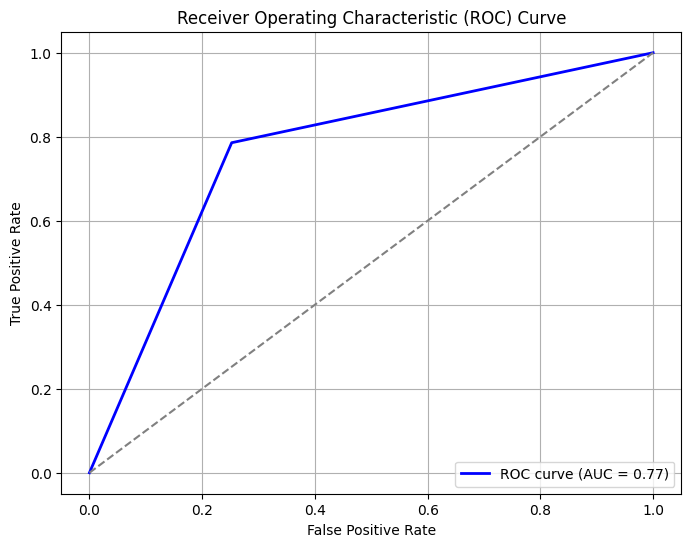

In [40]:
fpr, tpr, thresholds = roc_curve(Y_test, yhat_probs_gru)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## **BiLSTM**

In [33]:
def create_bilstm_model(bilstm_units=64, num_bilstm_layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(
        input_dim=len(d2v_model.wv.key_to_index) + 1,
        output_dim=20,
        input_length=X.shape[1],
        weights=[embedding_matrix],
        trainable=True
    ))

    for i in range(num_bilstm_layers):
        return_seq = (i < num_bilstm_layers - 1)
        model.add(Bidirectional(LSTM(units=bilstm_units, return_sequences=return_seq)))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model


In [34]:
model_bilstm = KerasClassifier(build_fn=create_bilstm_model, verbose=0)

# Definir la malla de hiperparámetros
param_grid_bilstm = {
    'bilstm_units': [64, 128],
    'num_bilstm_layers': [1, 2],
    'dropout_rate': [0.2],
    'learning_rate': [0.001],
    'batch_size': [32, 64],
    'epochs': [20, 50]
}

# Búsqueda en malla
grid_bilstm = GridSearchCV(estimator=model_bilstm, param_grid=param_grid_bilstm,cv=3,scoring='accuracy', verbose=2)


In [35]:
grid_result_bilstm = grid_bilstm.fit(X_train, Y_train, verbose=1)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Epoch 1/20
184/184 [==============================] - 13s 26ms/step - loss: 0.6744 - accuracy: 0.5749
Epoch 2/20
184/184 [==============================] - 5s 25ms/step - loss: 0.5205 - accuracy: 0.7391
Epoch 3/20
184/184 [==============================] - 5s 25ms/step - loss: 0.3337 - accuracy: 0.8595
Epoch 4/20
184/184 [==============================] - 4s 24ms/step - loss: 0.2443 - accuracy: 0.9036
Epoch 5/20
184/184 [==============================] - 5s 24ms/step - loss: 0.1822 - accuracy: 0.9332
Epoch 6/20
184/184 [==============================] - 5s 26ms/step - loss: 0.1457 - accuracy: 0.9475
Epoch 7/20
184/184 [==============================] - 5s 26ms/step - loss: 0.1157 - accuracy: 0.9596
Epoch 8/20
184/184 [==============================] - 5s 26ms/step - loss: 0.0930 - accuracy: 0.9690
Epoch 9/20
184/184 [==============================] - 5s 26ms/step - loss: 0.0743 - accuracy: 0.9761
Epoch 10/20
184/184 [========

In [36]:
print("🏆 Mejores parámetros:", grid_result_bilstm.best_params_)
print("✅ Mejor accuracy en CV:", grid_result_bilstm.best_score_)

results = pd.DataFrame(grid_result_bilstm.cv_results_)
results.to_csv('data/processed/resultados_bilstm.csv')
results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head()

🏆 Mejores parámetros: {'batch_size': 64, 'bilstm_units': 128, 'dropout_rate': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'num_bilstm_layers': 2}
✅ Mejor accuracy en CV: 0.7579856448402685


,params,mean_test_score,std_test_score,rank_test_score
13,"{'batch_size': 64, 'bilstm_units': 128, 'dropo...",0.757986,0.001407,1
8,"{'batch_size': 64, 'bilstm_units': 64, 'dropou...",0.756621,0.007337,2
9,"{'batch_size': 64, 'bilstm_units': 64, 'dropou...",0.755485,0.004529,3
5,"{'batch_size': 32, 'bilstm_units': 128, 'dropo...",0.754461,0.002138,4
12,"{'batch_size': 64, 'bilstm_units': 128, 'dropo...",0.752530,0.004242,5


In [39]:
yhat_probs_bilstm = grid_result_bilstm.predict(X_test)
df_pred = pd.DataFrame(yhat_probs_bilstm, columns=['prediccion'])
df_pred.to_csv('data/processed/predicciones_bilstm.csv', index=False)

69/69 [==============================] - 2s 25ms/step


### **Resultados**

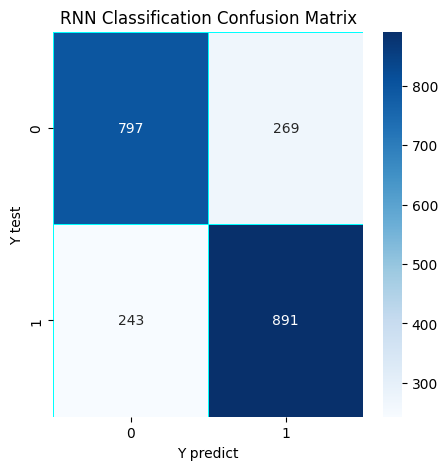

In [ ]:
gru_val = confusion_matrix(Y_test, yhat_probs_bilstm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(gru_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="Blues")
plt.title('RNN Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [41]:
metrics_bilstm=[]
precision = precision_score(Y_test, yhat_probs_bilstm)
recall = recall_score(Y_test, yhat_probs_bilstm)
f1 = f1_score(Y_test, yhat_probs_bilstm)
accuracy = accuracy_score(Y_test, yhat_probs_bilstm)

metrics_bilstm = [{
    'Modelo': 'biLSTM',
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4),
    'Accuracy': round(accuracy, 4)
}]

# Convertir en DataFrame y mostrarlo
df_metrics = pd.DataFrame(metrics_bilstm)
df_metrics

,Modelo,Precision,Recall,F1 Score,Accuracy
0,biLSTM,0.7657,0.784,0.7747,0.765


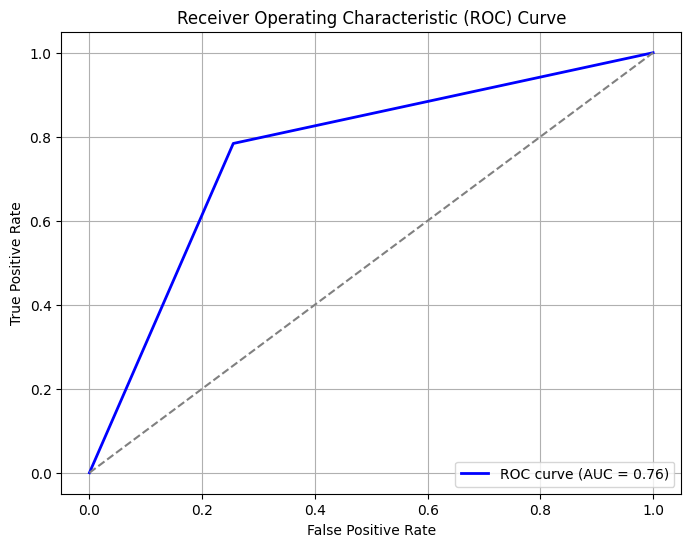

In [42]:
fpr, tpr, thresholds = roc_curve(Y_test, yhat_probs_bilstm)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## **Comparaciones finales**

In [46]:
metricas=pd.read_excel('data/processed/Meticas_totales.xlsx')
metricas

,Modelos,Precision,Recall,F1 Score,Accuracy
0,LSTM,0.7662,0.7804,0.7733,0.7641
1,RNN,0.7494,0.8069,0.7771,0.7614
2,GRU,0.7681,0.7857,0.7768,0.7673
3,biLSTM,0.7657,0.7840,0.7747,0.7650


En la comparación de modelos de redes neuronales recurrentes (LSTM, RNN, GRU y biLSTM), el modelo ``RNN`` obtuvo el mejor puntaje ``F1 (0.8069)``, lo que indica un equilibrio superior entre precisión y sensibilidad. Sin embargo, el modelo ``GRU`` mostró el mayor valor de`` precisión (0.7681)``, lo que significa que fue el más efectivo en reducir falsos positivos. En cuanto a ``accuracy``, los modelos ``GRU (0.7673)`` y ``biLSTM (0.7650) ``fueron los más altos, muy cercanos entre sí. Esto sugiere que, aunque el RNN sobresale en F1, el GRU mantiene un mejor balance general entre precisión, recall y exactitud, haciéndolo un candidato fuerte si se busca consistencia.